In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import seaborn as sb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import PIL
from PIL import Image
from tqdm import tqdm
from tqdm import trange
import tensorflow as tf
from tensorflow import keras
from keras.applications import NASNetLarge
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.callbacks import CSVLogger

In [3]:
#tf.__version__
print(keras.__version__)

2.5.0


In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6280984041961345149
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9146282803
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1809565996138757986
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:1d:00.0, compute capability: 6.1"
]


In [5]:
tumor_dir=r'C:\Users\Trabajo\Desktop\Python\Brain Cancer\data\Brain Tumor'
healthy_dir=r'C:\Users\Trabajo\Desktop\Python\Brain Cancer\data\Healthy'
filepaths=[]
labels=[]
dir_list=[tumor_dir, healthy_dir]

for i, d in enumerate(dir_list):
    flist=os.listdir(d)
    for f in flist:
        fpath=os.path.join(d,f)
        filepaths.append(fpath)
        if i==0:
            labels.append('cancer')
        else:
            labels.append('healthy')
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')    
df=pd.concat([Fseries, Lseries], axis=1)
df.head()

,filepaths,labels
0,C:\Users\Trabajo\Desktop\Python\Brain Cancer\d...,cancer
1,C:\Users\Trabajo\Desktop\Python\Brain Cancer\d...,cancer
2,C:\Users\Trabajo\Desktop\Python\Brain Cancer\d...,cancer
3,C:\Users\Trabajo\Desktop\Python\Brain Cancer\d...,cancer
4,C:\Users\Trabajo\Desktop\Python\Brain Cancer\d...,cancer


<AxesSubplot:xlabel='labels', ylabel='count'>

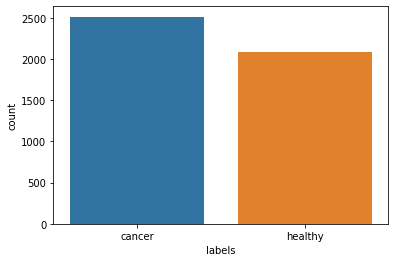

In [6]:
sb.countplot(data=df, x='labels')

In [7]:
def encoder_column(column):
    if column[0]=='healthy':
        return 0
    else:
        return 1
df['labels']=df[['labels']].apply(encoder_column, axis=1)

In [8]:
train_split=0.8
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=314)
test_df, val_df=train_test_split(dummy_df, train_size=0.5, shuffle=True)
print ('train_df length: ', len(train_df), '  test_df length: ', len(test_df), 
       ' valid_df length: ', len(val_df))


train_df length:  3680   test_df length:  460  valid_df length:  460


In [11]:
height=331
width=331
channels=3
batch_size=40
img_size=(height, width)
Xtrain=[]
Ytrain=[]
#Leemos train_df y aumentamos el dataset
for i in tqdm(range(len(train_df))):
    image=Image.open(train_df.iloc[i][0]).convert('RGB')
    image=image.resize(img_size)
    data=np.asarray(image, dtype=np.float)
    Xtrain.append(np.array(data/255., dtype=np.float))
    Ytrain.append(np.array(train_df.iloc[i][1]))
     
#Leemos val_df
Xval=[]
Yval=[]
for i in tqdm(range(len(val_df))):
    image=Image.open(val_df.iloc[i][0]).convert('RGB')
    image=image.resize(img_size)
    data=np.asarray(image, dtype=np.float)
    Xval.append(np.array(data/255., dtype=np.float))
    Yval.append(np.array(val_df.iloc[i][1]))
    

#Leemos train_df
Xtest=[]
Ytest=[]
for i in tqdm(range(len(test_df))):
    image=Image.open(test_df.iloc[i][0]).convert('RGB')
    image=image.resize(img_size)
    data=np.asarray(image, dtype=np.float)
    Xtest.append(np.array(data/255., dtype=np.float))
    Ytest.append(np.array(test_df.iloc[i][1]))

100%|███████████████████████████████████████████████████████████████████████████████| 460/460 [00:03<00:00, 147.59it/s]


In [13]:
Ytrain=np.array(Ytrain, dtype=np.float)
Yval=np.array(Yval, dtype=np.float)
Ytest=np.array(Ytest, dtype=np.float)
Xtrain= np.array(Xtrain, dtype=np.float)
Xval= np.array(Xval, dtype=np.float)
Xtest= np.array(Xtest, dtype=np.float)

In [31]:
#Cargamos el modelo pre-entrenado NasNetLarge sin la última capa
model=NASNetLarge(include_top=False, input_shape=(width, height, channels))

In [32]:
#Congelamos todas las capas del modelo
for layer in model.layers:
    layer.trainable = False
model.summary()

Model: "NASNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 331, 331, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 165, 165, 96) 2592        input_3[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 165, 165, 96) 384         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_520 (Activation)     (None, 165, 165, 96) 0           stem_bn1[0][0]                   
_____________________________________________________________________________________________

activation_729 (Activation)     (None, 11, 11, 672)  0           normal_bn_1_14[0][0]             
__________________________________________________________________________________________________
separable_conv_1_normal_left1_1 (None, 11, 11, 672)  468384      activation_721[0][0]             
__________________________________________________________________________________________________
separable_conv_1_normal_right1_ (None, 11, 11, 672)  457632      activation_723[0][0]             
__________________________________________________________________________________________________
separable_conv_1_normal_left2_1 (None, 11, 11, 672)  468384      activation_725[0][0]             
__________________________________________________________________________________________________
separable_conv_1_normal_right2_ (None, 11, 11, 672)  457632      activation_727[0][0]             
__________________________________________________________________________________________________
separable_

In [33]:
#Añadimos una última capa densa de 250 neuronas
modelFE=tf.keras.models.Sequential([
    model, 
    Flatten(),
    Dense(250, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid'),
])
# summarize
modelFE.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Functional)          (None, 11, 11, 4032)      84916818  
_________________________________________________________________
flatten_3 (Flatten)          (None, 487872)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 250)               121968250 
_________________________________________________________________
dropout_3 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 251       
Total params: 206,885,319
Trainable params: 121,968,501
Non-trainable params: 84,916,818
_________________________________________________________________


In [34]:
modelFE.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss=keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[keras.metrics.BinaryAccuracy()])

In [29]:
csv_logger = CSVLogger("model_history_log_NasNet_250.csv", append=True)

In [35]:
with tf.device("/device:GPU:0"):
    modelFE.fit(Xtrain, Ytrain, epochs=5, validation_data=(Xval, Yval), verbose=1,
        shuffle=True, batch_size=40, callbacks=[csv_logger])

Epoch 1/5
92/92 [==============================] - 102s 916ms/step - loss: 0.2348 - binary_accuracy: 0.8976 - val_loss: 0.1351 - val_binary_accuracy: 0.9587
Epoch 2/5
92/92 [==============================] - 80s 870ms/step - loss: 0.0502 - binary_accuracy: 0.9872 - val_loss: 0.1033 - val_binary_accuracy: 0.9652
Epoch 3/5
92/92 [==============================] - 79s 863ms/step - loss: 0.0198 - binary_accuracy: 0.9973 - val_loss: 0.0982 - val_binary_accuracy: 0.9652
Epoch 4/5
92/92 [==============================] - 75s 817ms/step - loss: 0.0101 - binary_accuracy: 0.9995 - val_loss: 0.0869 - val_binary_accuracy: 0.9717
Epoch 5/5
92/92 [==============================] - 76s 825ms/step - loss: 0.0057 - binary_accuracy: 0.9997 - val_loss: 0.0974 - val_binary_accuracy: 0.9674


In [40]:
modelFE.save('NasNet_250.h5')

C:\Users\Trabajo\anaconda3\envs\tf-latest2\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [36]:
def to_categorical(arr):
    for i in trange(len(arr)):
        if arr[i]<0.5:
            arr[i]=0
        else:
            arr[i]=1
    return arr  

100%|████████████████████████████████████████████████████████████████████████████| 460/460 [00:00<00:00, 459704.51it/s]


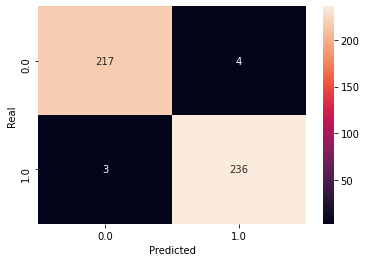

In [37]:
#Matriz de Confusión
Y=modelFE.predict(Xtest)
Y=np.array(Y.flatten())
Y=to_categorical(Y)
confusion_matrix = pd.crosstab(Ytest, Y, rownames=['Real'], colnames=['Predicted'])

sb.heatmap(confusion_matrix, annot=True, fmt='d')
plt.show()

In [39]:
from sklearn.metrics import classification_report
cl=classification_report(Ytest, Y)
print(cl)

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98       221
         1.0       0.98      0.99      0.99       239

    accuracy                           0.98       460
   macro avg       0.98      0.98      0.98       460
weighted avg       0.98      0.98      0.98       460

